# Análise Orçamentária e Forecast — Visão FP&A

Este projeto de portfólio demonstra um fluxo de trabalho completo de análise de dados, desde a criação de um conjunto de dados sintético até a geração de insights visuais. O projeto é dividido em duas partes principais:

1.  **Geração de Dados (`gerador_de_dados.py`):** Um script Python responsável por criar uma base de dados fictícia, porém realista, para a análise.
2.  **Análise e Visualização (Jupyter Notebook):** Um notebook onde os dados são explorados, processados e transformados em um painel de relatórios visuais.

O objetivo é exibir competências em programação com Python, manipulação de dados e comunicação de resultados em um estudo de caso focado em análise orçamentária para uma empresa imaginária, a "Companhia Alpha".

### Estrutura do Projeto e Ferramentas

O desenvolvimento foi realizado com as seguintes ferramentas e estrutura:

* **`gerador_de_dados.py`:**
    * **Propósito:** Criar um dataset consistente e controlado para a análise. O script utiliza as bibliotecas `numpy` e `pandas` para gerar valores de Orçado, Realizado e Forecast com base em parâmetros pré-definidos (crescimento mensal, variação aleatória, etc.).
    * **Reprodutibilidade:** O uso de uma semente (`seed`) na geração de números aleatórios garante que os dados sejam sempre os mesmos a cada execução, tornando a análise totalmente reproduzível por qualquer pessoa.

* **Jupyter Notebook de Análise:**
    * **Ambiente:** O formato de notebook foi escolhido por ser ideal para a análise exploratória, permitindo combinar blocos de código, texto explicativo e as visualizações geradas.
    * **Bibliotecas:** As protagonistas nesta fase são `pandas` (para os cálculos de desvio), `matplotlib` e `seaborn` (para a criação dos gráficos).

### Objetivos e Visualizações Geradas

O notebook de análise foi estruturado para gerar três tipos de saídas visuais, cada uma com um objetivo analítico específico:

1.  **Gráfico de Barras Anual:** Oferecer uma visão macro do desempenho de cada departamento ao final do ano.
2.  **Gráficos de Linha Mensais:** Analisar a evolução e a volatilidade das despesas ao longo do tempo.
3.  **Heatmap de Desvio Percentual:** Apontar de forma rápida os meses e departamentos com os desvios mais críticos, servindo como uma ferramenta de diagnóstico.

A análise a seguir detalha as conclusões extraídas a partir deste painel de visualizações, demonstrando a interpretação dos resultados gerados pelo código.

#### Importando os Dados

In [18]:
# 1. IMPORTAÇÃO DE BIBLIOTECAS
# ----------------------------
import pandas as pd                      # Manipulação eficiente de dados tabulares
import matplotlib.pyplot as plt          # Criação de gráficos e visualizações básicas
import matplotlib.dates as mdates        # Ferramentas para trabalhar com datas em gráficos
import matplotlib.ticker as ticker       # Personalização de escalas e formatação de eixos nos gráficos
import seaborn as sns                    # Estilização e layouts aprimorados para gráficos
from IPython.display import display      # Exibição amigável de dados em notebooks Jupyter

# Define a paleta padrão para TODOS os gráficos seaborn criados depois deste comando
sns.set_palette("colorblind")
palette = sns.color_palette("colorblind")

# 2. LEITURA E PRÉ-PROCESSAMENTO DOS DADOS
# ----------------------------------------
# Carrega o arquivo CSV do orçamento, garantindo suporte a caracteres especiais
df = pd.read_csv(
    "../dados/orcamento_empresa.csv",
    encoding="utf-8-sig"
)

# Converte a coluna "Data" do formato texto para objeto datetime, usando o formato "dia-mês"
df["Data"] = pd.to_datetime(df["Data"], format="%d-%b")

#### Análise Geral por Departamento

In [13]:
# --- 1. CÁLCULO ---
# Agrupa os dados por departamento, soma os valores das colunas principais,
# e adiciona colunas para desvio absoluto e percentual entre Realizado e Orçado
resumo_final = (
    df.groupby("Departamento")[["Orcado", "Realizado", "Forecast"]]
    .sum()
    .assign(
        Desvio_Real=lambda df_: df_.Realizado - df_.Orcado,        # Calcula desvio absoluto (Realizado - Orçado)
        Desvio_Perc=lambda df_: (df_.Realizado - df_.Orcado) / df_.Orcado  # Calcula desvio percentual
    )
)

# --- 2. FORMATAÇÃO OTIMIZADA E VISUAL ---
# Exibe o DataFrame com formatação financeira nacional e gradiente de cor para análise visual rápida dos desvios
display(
    resumo_final.style
        .format(
            {
                "Orcado": "R$ {:,.2f}",          # Formatação monetária padrão brasileiro
                "Realizado": "R$ {:,.2f}",
                "Forecast": "R$ {:,.2f}",
                "Desvio_Real": "R$ {:+,.2f}",    # Exibe sinal (+/-) no desvio absoluto
                "Desvio_Perc": "{:.2%}"          # Formatação percentual
            },
            decimal=",",
            thousands="."
        )
        .background_gradient(
            cmap="RdYlGn_r", 
            subset=["Desvio_Real", "Desvio_Perc"]    # Aplica gradiente apenas às colunas de desvio
        )
        .set_caption("Resumo Financeiro por Departamento com Análise Visual")    # Adiciona título ao DataFrame formatado
)

,Orcado,Realizado,Forecast,Desvio_Real,Desvio_Perc
Departamento,,,,,
Financeiro,"R$ 255.626,80","R$ 248.397,07","R$ 275.392,35","R$ -7.229,73","-2,83%"
Marketing,"R$ 208.964,54","R$ 200.431,82","R$ 196.395,98","R$ -8.532,72","-4,08%"
Operações,"R$ 208.253,31","R$ 197.550,45","R$ 200.574,71","R$ -10.702,86","-5,14%"
RH,"R$ 210.465,64","R$ 231.986,47","R$ 208.075,00","R$ +21.520,83","10,23%"
TI,"R$ 279.804,14","R$ 273.982,02","R$ 280.497,68","R$ -5.822,12","-2,08%"


#### Gráfico de Barras

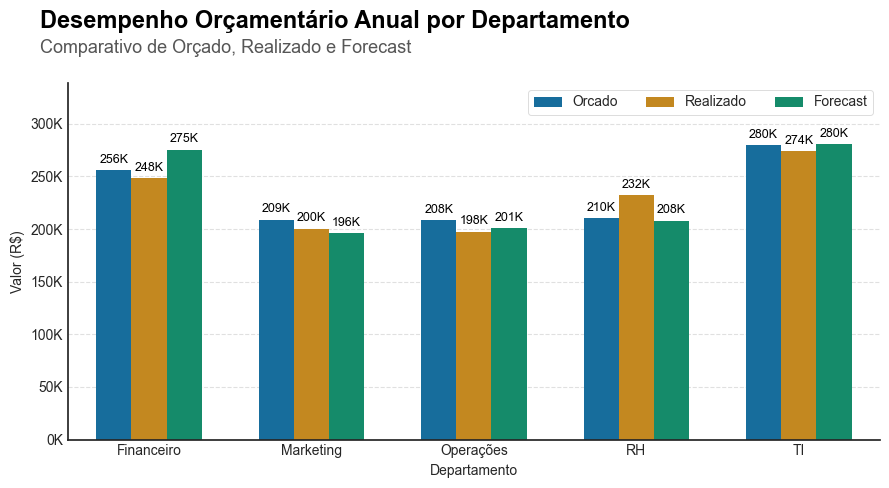

In [16]:
# Define o estilo visual do Matplotlib para um layout clean e minimalista
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(9, 5))

# 1. PLOTAGEM PRINCIPAL
# ------------------------------------------------------------------------------
# Gera gráfico de barras agrupadas convertendo o DataFrame para formato "long" (melt),
# facilitando a comparação entre Orçado, Realizado e Forecast por departamento
sns.barplot(
    data=resumo_final.reset_index().melt(
        id_vars='Departamento',
        value_vars=['Orcado', 'Realizado', 'Forecast'],
        var_name='Tipo de Valor'
    ),
    x='Departamento',
    y='value',
    hue='Tipo de Valor',
    #palette=["#30E542", "#268A30", "#08470E"],  # Paleta de cores personalizada para cada métrica
    ax=ax,
    width=0.65
)

# 2. ESTÉTICA E ANOTAÇÕES
# ------------------------------------------------------------------------------
# Adiciona títulos personalizados ao gráfico, posicionados manualmente na figura
fig.text(0.05, 0.93, "Desempenho Orçamentário Anual por Departamento",
         fontsize=17, fontweight='bold', ha='left', color="#000000")
fig.text(0.05, 0.88, "Comparativo de Orçado, Realizado e Forecast",
         fontsize=13, ha='left', color="#565656")

# Adiciona os rótulos dos eixos X e Y
ax.set(xlabel="Departamento", ylabel="Valor (R$)", title=None)

# Formata os valores do eixo Y em milhares (exemplo: 12K)
formatter = ticker.FuncFormatter(lambda y, pos: f'{y/1000:.0f}K')
ax.yaxis.set_major_formatter(formatter)
# Ajusta limite superior para não cortar rótulos acima das barras
ax.set_ylim(top=ax.get_ylim()[1] * 1.15)
# Adiciona linhas de grade horizontais para facilitar a leitura dos valores
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adiciona rótulos diretamente sobre as barras, garantindo contraste e legibilidade
for i, container in enumerate(ax.containers):
    cor_rotulo = 'black'
    labels = [f'{v/1000:.0f}K' for v in container.datavalues]
    ax.bar_label(
        container,
        labels=labels,
        size=9,
        padding=3,
        color=cor_rotulo
    )

# Personaliza a legenda: posicionamento, cor de fundo, borda e transparência
legenda = ax.legend(
    title=None,
    frameon=True,
    loc='upper right',
    ncol=3,
    facecolor='white',
    edgecolor='#565656',
    framealpha=0.2,
    bbox_to_anchor=(1, 1) 
)
legenda.get_frame().set_linewidth(0.7)

# Remove as bordas superior e direita do gráfico para um visual mais limpo
sns.despine()

# 3. RENDERIZAÇÃO FINAL
# ------------------------------------------------------------------------------
# Ajusta o layout do gráfico para evitar sobreposição e exibe a figura final
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

#### Evolução Mensal do Orçamento

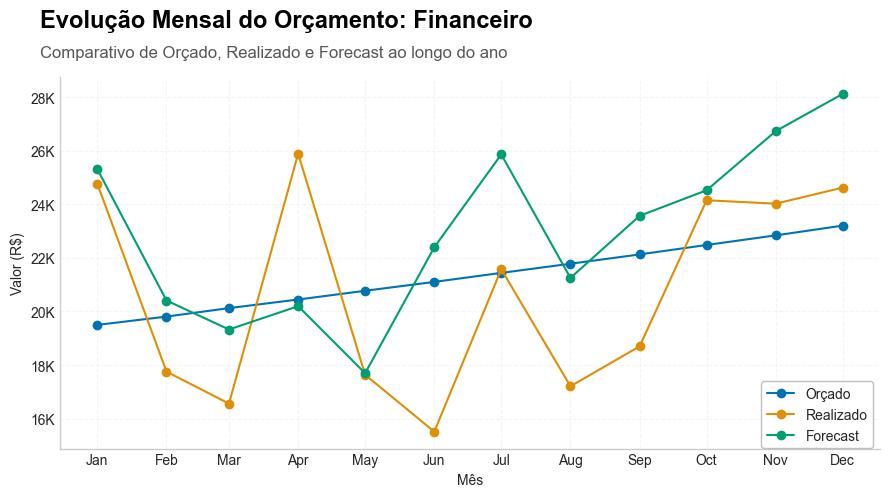

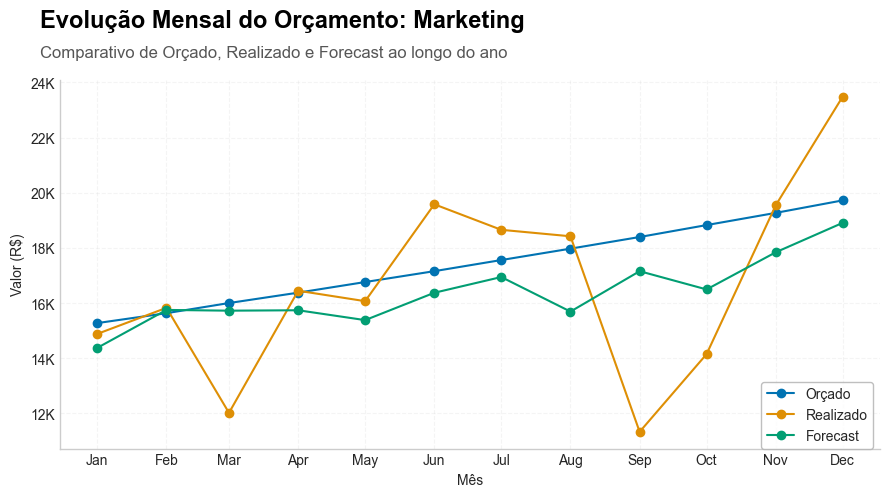

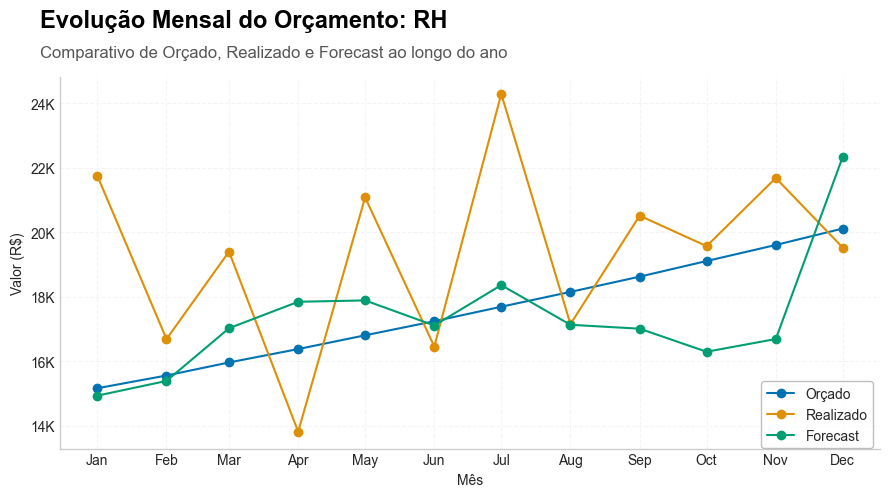

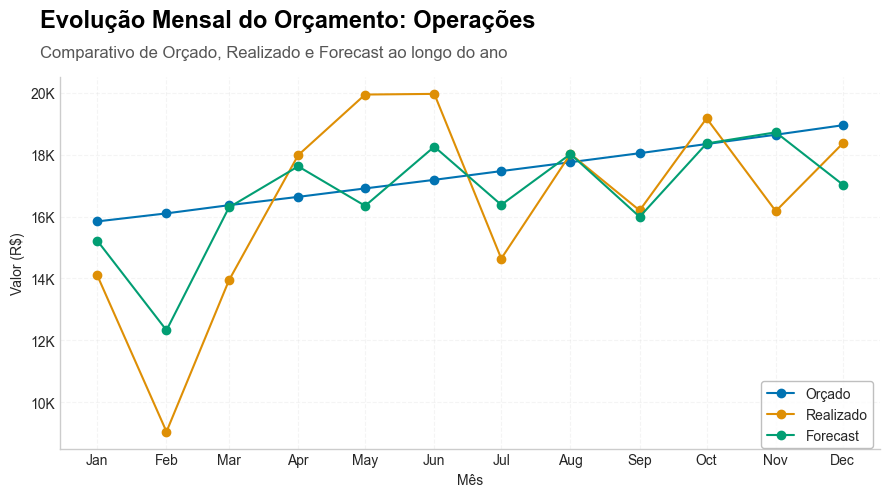

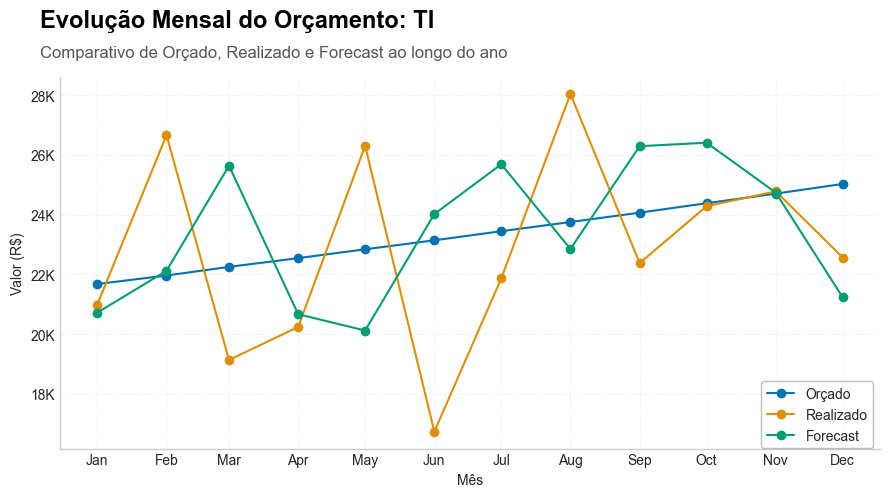

In [20]:
# 1. SETUP INICIAL E IDENTIFICAÇÃO DOS DEPARTAMENTOS
# ---------------------------------------------------
# Define o estilo global dos gráficos (grade branca com linhas de fundo suaves)
plt.style.use('seaborn-v0_8-whitegrid')

# Extrai os departamentos únicos para gerar um gráfico separado para cada um
departamentos = df['Departamento'].unique()

# 2. LOOP PARA GERAR UM GRÁFICO POR DEPARTAMENTO
# -----------------------------------------------
# Gera, para cada departamento, um gráfico de evolução mensal das métricas financeiras
for depto in departamentos:
    
    # --- Filtragem dos Dados ---
    # Seleciona apenas os registros correspondentes ao departamento atual
    df_depto = df[df['Departamento'] == depto].copy()

    # --- Inicialização da Figura ---
    # Cria uma nova figura e eixos para o gráfico do departamento atual
    fig, ax = plt.subplots(figsize=(9, 5))

    # --- Plotagem das Métricas ---
    # Plota as linhas de evolução de Orçado, Realizado e Forecast ao longo dos meses
    ax.plot(df_depto['Data'], df_depto['Orcado'], marker='o', linestyle='-', color=palette[0], label='Orçado')
    ax.plot(df_depto['Data'], df_depto['Realizado'], marker='o', linestyle='-', color=palette[1], label='Realizado')
    ax.plot(df_depto['Data'], df_depto['Forecast'], marker='o', linestyle='-', color=palette[2], label='Forecast')

    # --- Títulos e Subtítulos Dinâmicos ---
    # Adiciona título principal e subtítulo descritivo ao gráfico, alinhados à esquerda
    fig.text(0.05, 0.95, f'Evolução Mensal do Orçamento: {depto}', fontsize=17, fontweight='bold', ha='left', color="#000000")
    fig.text(0.05, 0.89, 'Comparativo de Orçado, Realizado e Forecast ao longo do ano', fontsize=12, ha='left', color="#565656")

    # --- Formatação dos Eixos ---
    # Exibe valores do eixo Y em milhares (K)
    formatter = ticker.FuncFormatter(lambda y, pos: f'{y/1000:.0f}K')
    ax.yaxis.set_major_formatter(formatter)

    # Mostra apenas os meses abreviados no eixo X
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    # Adiciona os rótulos dos eixos X e Y
    ax.set(xlabel="Mês", ylabel="Valor (R$)")
    
    # Adiciona linhas de grade horizontais e verticais com baixa opacidade para facilitar leitura sem poluir visualmente
    ax.grid(axis='y', linestyle='--', alpha=0.2) 
    ax.grid(axis='x', linestyle='--', alpha=0.2) 

    # --- Legenda e Ajustes Visuais ---
    # Posiciona e estiliza a legenda para melhor contraste e leitura
    ax.legend(
        title=None, 
        loc='upper right', 
        frameon=True, 
        facecolor='white', 
        edgecolor='#B0B0B0',
        bbox_to_anchor=(1, 0.2)
    )
    
    # Remove bordas superiores e direitas para um visual mais limpo
    sns.despine()

    # Ajusta o layout do gráfico para evitar sobreposição de elementos visuais
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    
    # Renderiza o gráfico final para o departamento atual
    plt.show()

#### Heatmap

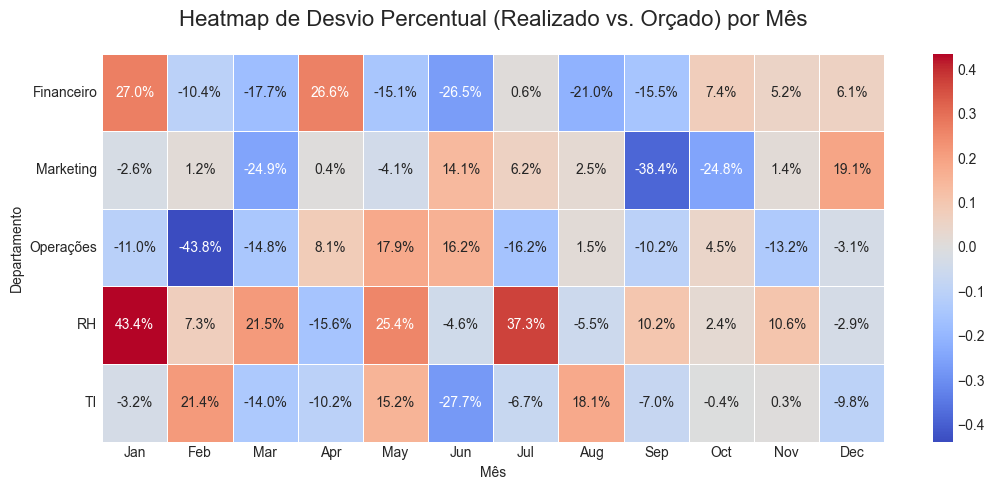

In [ ]:
# 1. PREPARAÇÃO DOS DADOS PARA O HEATMAP
# ----------------------------------------
# Adiciona coluna de desvio percentual no DataFrame principal, caso ainda não exista
if 'Desvio_Perc' not in df.columns:
    df['Desvio_Perc'] = (df['Realizado'] - df['Orcado']) / df['Orcado']

# Cria uma tabela dinâmica (pivot table) com departamentos nas linhas e meses nas colunas,
# preenchendo cada célula com o desvio percentual entre Realizado e Orçado
tabela_desvio = df.pivot_table(
    values='Desvio_Perc', 
    index='Departamento', 
    columns=df['Data']
)

# Formata os nomes das colunas (datas) para mostrar apenas a abreviação do mês (ex: Jan, Fev)
tabela_desvio.columns = tabela_desvio.columns.strftime('%b')

# 2. CRIAÇÃO DO GRÁFICO DE HEATMAP
# ----------------------------------
# Define o tamanho da figura do heatmap
plt.figure(figsize=(11, 5))

# Gera o heatmap do desvio percentual usando Seaborn, com anotação dos valores em cada célula
heatmap = sns.heatmap(
    tabela_desvio,
    annot=True,               # Exibe os valores percentuais nas células
    fmt='.1%',                # Formata como porcentagem com uma casa decimal
    cmap='coolwarm',          # Paleta de cores
    linewidths=.5,            # Linhas divisórias entre as células
    linecolor='white'         # Cor das linhas divisórias
)

# 3. ESTÉTICA E TÍTULOS
# ---------------------
# Adiciona título ao gráfico
plt.title('Heatmap de Desvio Percentual (Realizado vs. Orçado) por Mês', fontsize=16, pad=20)

# Define rótulos dos eixos para maior clareza
plt.ylabel("Departamento")
plt.xlabel("Mês")

# Ajusta rotação dos rótulos para melhor legibilidade
plt.xticks(rotation=0) 
plt.yticks(rotation=0)

# 4. RENDERIZAÇÃO FINAL
# ---------------------
# Ajusta o layout da figura para evitar sobreposição e exibe o gráfico
plt.tight_layout()
plt.show()

# Conclusão da Análise Orçamentária

A análise dos dados da empresa fictícia "Companhia Alpha" permite extrair as seguintes conclusões, demonstrando a aplicação de técnicas de visualização de dados para avaliação de desempenho.

### Resumo Geral do Desempenho Simulado

Na simulação, o resultado consolidado mostra que a maioria dos departamentos operou abaixo do orçamento previsto. No entanto, o departamento de Recursos Humanos (RH) se destaca como o único a exceder seus custos planejados, com um desvio de 10,23%. Em contrapartida, os departamentos de Operações (-5,14%) e Marketing (-4,08%) foram os que apresentaram as maiores economias.

### Destaques por Departamento (Demonstração)

* **Recursos Humanos (RH):**
    * **Desempenho:** Foi o único departamento com gastos simulados acima do orçamento (+R$ 21.520,83).
    * **Causa Raiz:** O heatmap revela que o desvio foi impulsionado por picos de gastos em meses específicos, principalmente em Janeiro (+43,4%), Julho (+37,3%) e Maio (+25,4%). Num cenário real, isso sugeriria investigar eventos não planejados.

* **Operações:**
    * **Desempenho:** Apresentou a maior economia percentual em relação ao orçamento (-5,14%).
    * **Volatilidade:** O departamento mostrou grande volatilidade mensal, com um desvio negativo extremo em Fevereiro (-43,8%), indicando a importância de analisar não só o resultado anual, mas também as flutuações.

* **Marketing:**
    * **Desempenho:** Também operou com uma economia relevante (-4,08%).
    * **Análise Mensal:** O principal desvio negativo ocorreu em Setembro (-38,4%). Em uma empresa real, isso levantaria a questão se uma campanha importante foi cancelada ou adiada.

* **Financeiro e TI:**
    * **Desempenho:** Ambos os departamentos terminaram o ano com uma leve economia, de -2,83% e -2,08%, respectivamente.
    * **Padrão:** Apresentaram flutuações mensais mais contidas, demonstrando um controle orçamentário mais estável na simulação.

### Conclusão do Exercício Analítico

Este projeto demonstrou que, através da aplicação de técnicas de análise exploratória e visualização de dados em Python, é possível transformar dados brutos em um painel de insights claro e objetivo. As visualizações geradas permitem que gestores identifiquem rapidamente os principais desvios, questionem suas causas e tomem decisões mais bem informadas.

Para a fictícia Companhia Alpha, as recomendações se concentrariam na investigação dos gastos de RH e na revisão do planejamento de Operações. Assim, o projeto cumpre seu objetivo de exibir competências analíticas de forma prática e aplicada.